## Beard Filter

In [33]:
import cv2,sys,dlib,time,math
import numpy as np
import faceBlendCommon as fbc
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [34]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [35]:
FACE_DOWNSAMPLE_RATIO = 1
RESIZE_HEIGHT = 480

In [36]:
# Points corresponding to Dlib which have been marked on the beard
selectedIndex = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                 31, 32, 33, 34, 35, 55, 56, 57, 58, 59]

In [37]:
# Read points corresponding to beard, stored in text files
def getSavedPoints(beardPointsFile):
  points = []
  lines = np.loadtxt(beardPointsFile, dtype='uint16')
  
  for p in lines:
    points.append((p[0], p[1]))
  
  return points 

In [38]:
# Load face detection and pose estimation models.
modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)

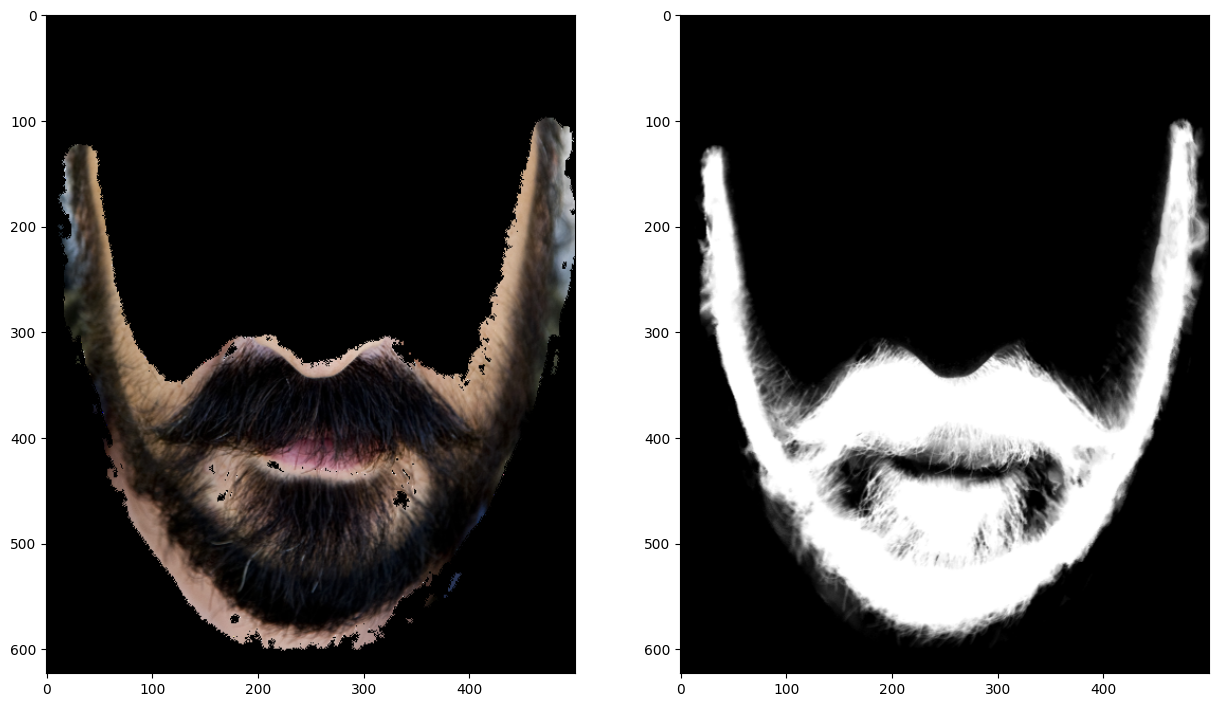

In [39]:
# Load the beard image with alpha mask 
overlayFile = DATA_PATH + "images/beard1.png"
imgWithMask = cv2.imread(overlayFile,cv2.IMREAD_UNCHANGED)

# split the 4 channels
b,g,r,a = cv2.split(imgWithMask)

# Take the first 3 channels and create the bgr image to be warped
beard = cv2.merge((b,g,r))
beard = np.float32(beard)/255

# Take the 4th channel and create the alpha mask used for blending
beardAlphaMask = cv2.merge((a,a,a))
beardAlphaMask = np.float32(beardAlphaMask)
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(beard[...,::-1])
plt.subplot(122);plt.imshow(np.uint8(beardAlphaMask[...,::-1]))

In [40]:
# Read the points marked on the beard
featurePoints1 = getSavedPoints( overlayFile + ".txt")

# Find delanauy traingulation for convex hull points
sizeImg1 = beard.shape    
rect = (0, 0, sizeImg1[1], sizeImg1[0])
dt = fbc.calculateDelaunayTriangles(rect, featurePoints1)

if len(dt) == 0:
    print("No delaunay triangle found")

23
16
15
22
9
15
24
6
24
7
24
22
24
20
22
17
21
15
20
20
20
16
19
14
19
19
24
17
19
19
18
20
23


False

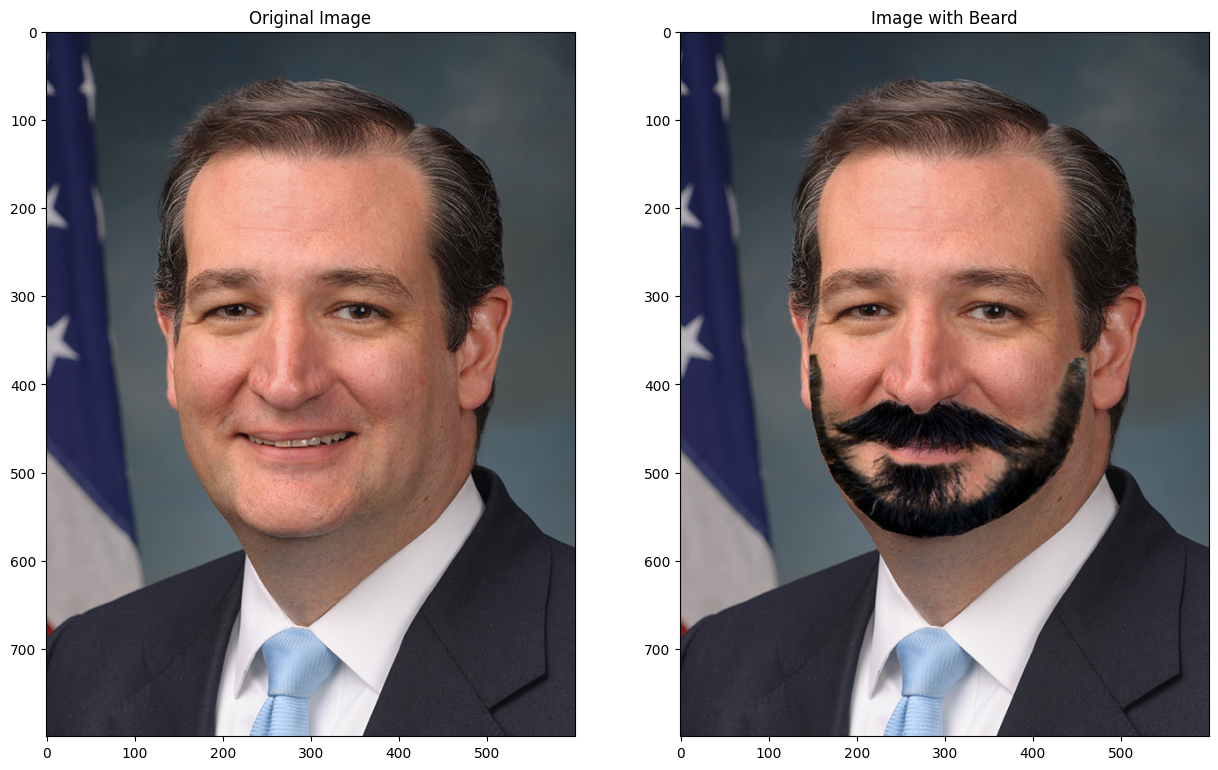

In [46]:
imageFile = DATA_PATH + "images/ted_cruz.jpg";
targetImage = cv2.imread(imageFile)
# height, width = targetImage.shape[:2]
# IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
# targetImage = cv2.resize(targetImage,None,
#                  fx=1.0/IMAGE_RESIZE,
#                  fy=1.0/IMAGE_RESIZE,
#                  interpolation = cv2.INTER_LINEAR)

points2 = fbc.getLandmarks(detector, predictor, cv2.cvtColor(targetImage, cv2.COLOR_BGR2RGB), FACE_DOWNSAMPLE_RATIO)
featurePoints2 = []
for p in selectedIndex:
    pt = points2[p]
    # pt = fbc.constrainPoint(pt, width, height)
    featurePoints2.append(pt)

targetImage = np.float32(targetImage)/255

beardWarped = np.zeros(targetImage.shape)
beardAlphaWarped = np.zeros(targetImage.shape)
b,g,r = cv2.split(targetImage)

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    print(dt[i][j])
    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
      t1.append(featurePoints1[dt[i][j]])
      t2.append(featurePoints2[dt[i][j]])

    fbc.warpTriangle(beard, beardWarped, t1, t2)
    fbc.warpTriangle(beardAlphaMask, beardAlphaWarped, t1, t2)

beardWarpedMask = beardAlphaWarped/255
temp1 = np.multiply(targetImage, 1.0 - beardWarpedMask)
temp2 = np.multiply(beardWarped, beardWarpedMask)

out = temp1 + temp2;
plt.figure(figsize=[15,10])
plt.subplot(121);plt.imshow(targetImage[...,::-1]);plt.title("Original Image")
plt.subplot(122);plt.imshow(out[...,::-1]);plt.title("Image with Beard")
cv2.imwrite("results/beardify.jpg", np.uint8(255*out))